# **Tutorial for hierarchical Bayesian inference for Reinforcement Learning - Sequential Sampling Models.**

This is a (preview) tutorial for using the HSSM Python package to simultaneously estimate reinforcement learning parameters and decision parameters within a fully hierarchical bayesian estimation framework, including steps for constructing HSSM-compatible likelihoods/distributions and sampling from the posterior. Further, the plots to assess the recovery of model parameters are also shown. 

The module uses the reinforcement learning sequential sampling model (RLSSM), a reinforcement learning model that replaces the standard “softmax” choice function with a drift diffusion process with collapsing bounds (referred to as the 'angle' model hereon). The softmax and sequential sampling process is equivalent for capturing choice proportions, but the angle model also takes RT distributions into account; options are provided to also only fit RL parameters without RT. The RLSSM estimates trial-by-trial drift rate as a scaled difference in expected rewards (expected reward for upper bound alternative minus expected reward for lower bound alternative). Expected rewards are updated with a delta learning rule using either a single learning rate or with separate learning rates for positive and negative prediction errors. The model also includes the standard angle parameters. The broader RLSSM framework is described in detail in [Pedersen, Frank & Biele (2017)](https://ski.clps.brown.edu/papers/PedersenEtAl_RLDDM.pdf) and [Fengler, Bera, Pedersen & Frank (2022)](https://direct.mit.edu/jocn/article/34/10/1780/112585/Beyond-Drift-Diffusion-Models-Fitting-a-Broad).

In [ ]:
# Import necessary libraries

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import spearmanr

import pymc as pm
import pytensor.tensor as pt

import jax
import jax.numpy as jnp
from jax import jit, lax, vmap

from hssm.distribution_utils.onnx.onnx import make_jax_logp_funcs_from_onnx
from hssm.distribution_utils.dist import make_hssm_rv
from hssm.rl_utils import *

/users/kbera1/.conda/envs/RLDM_tutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the demo dataset. 
This data file contains (synthetic) data from a simulated 2-armed bandit task. We examine the dataset -- it contains the typical columns that are expected from a canonical instrumental learning task. `participant_id` identifies the subject id, `trial` identifies the sequence of trials within the subject data, `response` and `rt` are the data columns recorded for each trial, `feedback` column shows the reward obtained on a given trial and `correct` records whether the response was correct. 

In [2]:
savefile = np.load("./RLDM_tutorial/demo_data.npy", allow_pickle=True).item()
dataset = savefile['data']

# Examine the dataset
dataset.head()

participant_id  trial  response        rt  feedback  correct
0               0      0       0.0  0.935602  0.126686      0.0
1               0      1       0.0  1.114379  0.173100      0.0
2               0      2       0.0  0.564311  0.444935      0.0
3               0      3       0.0  2.885860  0.307207      0.0
4               0      4       0.0  0.532113  0.177911      0.0

## Construct the likelihood definition
For Bayesian inference, we need to provide a likelihood definition for our RLSSM model. Here, we construct this likelihood using JAX (a GPU-accelerated package for efficient compute, autodiff, etc.). 

At a high-level, the likelihood definition utilizes a neural network called LAN ([Likelihood Approximation Network](https://elifesciences.org/articles/65074)) for computing the trial-by-trial likelihood from our SSM model. The outer JAX function wraps the forward pass to this LAN alongside all the necessary RL computations from our RLSSM model. 

In [3]:
# Load the LAN model from ONNX file
jax_LAN_logp = make_jax_logp_funcs_from_onnx(
    "./RLDM_tutorial/angle.onnx", [True] * 5
)[0]

# Define the JAX function to compute the forward pass of the LAN model. 
# This function outputs the trial-by-trial log probabilities for our data.
def jax_call_LAN(LAN_matrix):
    net_input = jnp.array(LAN_matrix)
    LL = jax_LAN_logp(
        net_input[:, 5:7],
        net_input[:, 0],
        net_input[:, 1],
        net_input[:, 2],
        net_input[:, 3],
        net_input[:, 4],
    )

    return LL

In [4]:
def jax_LL_func(
    subj_index,
    data,
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,
):

    # Extracting the necessary data from the input
    ntrials_subj = 200
    rt = data[:, 0]
    response = data[:, 1]
    
    subj = jnp.astype(subj_index, jnp.int32)

    # Extracting the parameters and data for the specific subject
    subj_rl_alpha = jax.lax.dynamic_slice(rl_alpha, [subj * ntrials_subj], [ntrials_subj])
    subj_scaler = jax.lax.dynamic_slice(scaler, [subj * ntrials_subj], [ntrials_subj])
    subj_a = jax.lax.dynamic_slice(a, [subj * ntrials_subj], [ntrials_subj])
    subj_z = jax.lax.dynamic_slice(z, [subj * ntrials_subj], [ntrials_subj])
    subj_t = jax.lax.dynamic_slice(t, [subj * ntrials_subj], [ntrials_subj])
    subj_theta = jax.lax.dynamic_slice(theta, [subj * ntrials_subj], [ntrials_subj])

    subj_trial = jax.lax.dynamic_slice(trial, [subj * ntrials_subj], [ntrials_subj])
    subj_response = jax.lax.dynamic_slice(response, [subj * ntrials_subj], [ntrials_subj])
    subj_rt = jax.lax.dynamic_slice(rt, [subj * ntrials_subj], [ntrials_subj])
    subj_feedback = jax.lax.dynamic_slice(feedback, [subj * ntrials_subj], [ntrials_subj])
    
    # Initialize the LAN matrix that will hold the trial-by-trial data
    # The matrix will have 7 columns: data (choice, rt) and parameters of the angle model (v, a, z, t, theta)
    # The number of rows is equal to the number of trials for the subject
    LAN_matrix_init = jnp.zeros((ntrials_subj, 7))
    q_val = jnp.ones(2) * 0.5

    # function to process each trial
    def process_trial(carry, inputs):
        q_val, LL, LAN_matrix, t = carry
        state, action, rt, reward = inputs
        state = jnp.astype(state, jnp.int32)
        action = jnp.astype(action, jnp.int32)

        # drift rate on each trial depends on difference in expected rewards for the two alternatives: 
        # drift rate = (q_up - q_low) * scaler where 
        # the scaler parameter describes the weight to put on the difference in q-values. 
        computed_v = (q_val[1] - q_val[0]) * subj_scaler[t]

        # compute the reward prediction error
        delta_RL = reward - q_val[action]

        # update the q-values using the RL learning rule (here, simple TD rule)
        q_val = q_val.at[action].set(q_val[action] + subj_rl_alpha[t] * delta_RL)

        # update the LAN_matrix with the current trial data
        # The first column is the drift rate, followed by the parameters a, z, t, theta, rt, and action
        LAN_matrix = LAN_matrix.at[t, :].set(
            jnp.array([computed_v, subj_a[t], subj_z[t], subj_t[t], subj_theta[t], rt, action])
        )

        return (q_val, LL, LAN_matrix, t + 1), None

    trials = (
        subj_trial,
        subj_response,
        subj_rt,
        subj_feedback,
    )
    (q_val, LL, LAN_matrix, _), _ = lax.scan(
        process_trial, (q_val, 0.0, LAN_matrix_init, 0), trials
    )

    # forward pass through the LAN to compute log likelihoods
    LL = jax_call_LAN(LAN_matrix)
    
    return LL

### Make a test call to the JAX likelihood function

In [5]:
# Parallelize (vectorize) the likelihood computation across subjects. 'subj_index' arg to the JAX likelihood should be vectorized.
def vec_logp(*args):
    vmap = jax.vmap(
        jax_LL_func,
        # Only the first argument (subj), needs to be vectorized
        in_axes=(0, None, None, None, None, None, None, None, None, None, None),
    )
    #return jnp.sum(vmap(*args))
    res_LL = vmap(*args).ravel()

    res_LL = jnp.reshape(res_LL, (len(res_LL), 1))

    return res_LL


# Get jitted vectorized logp function.
jitted_vec_logp = jax.jit(vec_logp)

In [6]:
# prepare the data for the likelihood function
participant_id = dataset["participant_id"].values
trial = dataset["trial"].values
response = dataset["response"].values
feedback = dataset["feedback"].values
rt = dataset["rt"].values

num_subj = len(np.unique(dataset["participant_id"].values))
ntrials = num_subj * 200

# create parameter arrays to be passed to the likelihood function
rl_alpha = np.ones(ntrials) * 0.60
scaler = np.ones(ntrials) * 3.2
a = np.ones(ntrials) * 1.2
z = np.ones(ntrials) * 0.1
t = np.ones(ntrials) * 0.1
theta = np.ones(ntrials) * 0.1

subj = np.arange(20) 

In [7]:
# make a call to the JAX likelihood function
jax_LL = jitted_vec_logp(subj,
    np.column_stack((rt, response)),
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,)

# Print the sum of the log likelihoods for all subjects
print(np.sum(jax_LL))

-6879.15262965923


## Construct HSSM-compatible PyMC distribution from a simulator and JAX likelihood callable

We now construct a custom model that is compatible with HSSM and PyMC. Note that HSSM internally constructs a PyMC object (which is used for sampling) based on the user-specified HSSM model. In other words, we are peeling the abstration layers conveniently afforded by HSSM to directly use the core machinery of HSSM. This advanced [HSSM tutorial](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/) explains how to use HSSM when starting from the very basics of a model -- a simulator and a JAX likelihood callable. 

The simulator function is used for generating samples from the model (for posterior predictives, etc.) and the likelihood callable is employed for sampling/inference. This preview tutorial exposes the key flexibility of the HSSM for use in fitting RLSSM models. Therefore, the subsequent tutorial will focus only on the sampling/inference aspect. We create a dummy simulator function to bypass the need for defining the actual simulator.

### Step 1: Define a pytensor RandomVariable

In [8]:
# Define the list of parameters to be used in the model
list_params = ['rl_alpha', 'scaler', 'a', 'z', 't', 'theta']

# create a dummy simulator function to be used with the decorator
def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):

    sim_rt = np.random.uniform(0.2, 0.6, n_samples)
    sim_ch = np.random.randint(0, 2, n_samples)

    return np.column_stack([sim_rt, sim_ch])

my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="custom", choices=[0, 1, 2], obs_dim=2
)(my_wrapped_simulator)

# Step 1: Define a pytensor RandomVariable
# We use the `make_hssm_rv` function to create a custom RandomVariable that will be used in the PyMC model.
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

### Step 2: Define a likelihood function

In [9]:
# Step 2: Define a likelihood function
# We use the JAX function defined above to create a likelihood callable.
# The `make_likelihood_callable_rlssm` function is a utility that wraps the JAX function into a PyMC-compatible likelihood callable.
logp_jax_op = make_likelihood_callable_rlssm(
    loglik=jax_LL_func,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[True] * 10,
    params_only=None,
)

In [10]:
# Test the constrcuted likelihood function
# We will use the same parameters and data as before to test the likelihood function.
test_logp_out = logp_jax_op(
    subj,
    np.column_stack((rt, response)),
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,
)
LL = test_logp_out.eval()


# Print the sum of the log likelihoods for all subjects
# This should match the output from the JAX function.
print(np.sum(jax_LL))

-6879.15262965923


### Step 3: Define a distribution

In [11]:
# Step 3: Define a distribution
# We use the `make_distribution` function to create a custom distribution that will be used in the PyMC model.
# The distribution is defined with the custom RandomVariable, the likelihood function, and the list of parameters.
# We also specify bounds for the parameters and additional fields that will be used in the model.
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=list_params,
    bounds=dict(rl_alpha=(0.01, 1), scaler=(2, 5), a=(0.3, 2.5), z=(0.1, 0.9), t=(0.1, 2.0), theta=(0.0, 1.2)),
    extra_fields=[participant_id, trial, feedback]
)

# Pass the test distribution to PyMC

In [12]:
# Define metadata for the model
num_subj = 20 
num_trials_per_subj = 200
ntrials = num_subj * num_trials_per_subj

# construct the PyMC model
with pm.Model() as model:

    # Group-level parameters
    group_rl_alpha_mean = pm.Uniform("group_rl_alpha_mean", lower=0.1, upper=1.0, initval=0.3)
    group_rl_alpha_sd = pm.Uniform("group_rl_alpha_sd", lower=0.0, upper=1.0)

    group_scaler_mean = pm.Uniform("group_scaler_mean", lower=1.0, upper=4.0, initval=1.5)
    group_scaler_sd = pm.Uniform("group_scaler_sd", lower=0.0, upper=1.0)

    group_a_mean = pm.Uniform("group_a_mean", lower=0.3, upper=2.5, initval=1.0)
    group_a_sd = pm.Uniform("group_a_sd", lower=0.0, upper=1.0)

    group_z_mean = pm.Uniform("group_z_mean", lower=0.10, upper=0.90, initval=0.2)
    group_z_sd = pm.Uniform("group_z_sd", lower=0.0, upper=1.0)

    group_t_mean = pm.Uniform("group_t_mean", lower=0.0, upper=2.0, initval=0.2)
    group_t_sd = pm.Uniform("group_t_sd", lower=0.0, upper=1.0)

    group_theta_mean = pm.Uniform("group_theta_mean", lower=0.0, upper=1.2, initval=0.3)
    group_theta_sd = pm.Uniform("group_theta_sd", lower=0.0, upper=1.0)

    # Non-centered parameterization using standard normal variables
    z_rl_alpha = pm.Normal("z_rl_alpha", mu=0, sigma=1, shape=num_subj)
    subj_rl_alpha = pm.Deterministic(
        "subj_rl_alpha",
        pm.math.clip(group_rl_alpha_mean + group_rl_alpha_sd * z_rl_alpha, 0.1, 1.0)
    )
    rl_alpha_det = pm.Deterministic("rl_alpha_det", pt.repeat(subj_rl_alpha, num_trials_per_subj))

    z_scaler = pm.Normal("z_scaler", mu=0, sigma=1, shape=num_subj)
    subj_scaler = pm.Deterministic(
        "subj_scaler",
        pm.math.clip(group_scaler_mean + group_scaler_sd * z_scaler, 1.0, 4.0)
    )
    scaler_det = pm.Deterministic("scaler_det", pt.repeat(subj_scaler, num_trials_per_subj))

    z_a = pm.Normal("z_a", mu=0, sigma=1, shape=num_subj)
    subj_a = pm.Deterministic(
        "subj_a",
        pm.math.clip(group_a_mean + group_a_sd * z_a, 0.3, 2.5)
    )
    a_det = pm.Deterministic("a_det", pt.repeat(subj_a, num_trials_per_subj))

    z_z = pm.Normal("z_z", mu=0, sigma=1, shape=num_subj)
    subj_z = pm.Deterministic(
        "subj_z",
        pm.math.clip(group_z_mean + group_z_sd * z_z, 0.10, 0.90)
    )
    z_det = pm.Deterministic("z_det", pt.repeat(subj_z, num_trials_per_subj))

    z_t = pm.Normal("z_t", mu=0, sigma=1, shape=num_subj)
    subj_t = pm.Deterministic(
        "subj_t",
        pm.math.clip(group_t_mean + group_t_sd * z_t, 0.0, 2.0)
    )
    t_det = pm.Deterministic("t_det", pt.repeat(subj_t, num_trials_per_subj))

    z_theta = pm.Normal("z_theta", mu=0, sigma=1, shape=num_subj)
    subj_theta = pm.Deterministic(
        "subj_theta",
        pm.math.clip(group_theta_mean + group_theta_sd * z_theta, 0.0, 1.2)
    )
    theta_det = pm.Deterministic("theta_det", pt.repeat(subj_theta, num_trials_per_subj))

    # load the data into the custom distribution
    participant_id = dataset["participant_id"].values.astype(np.float32)
    trial = dataset["trial"].values.astype(np.float32)
    response = dataset["response"].values.astype(np.float32)
    rt = dataset["rt"].values.astype(np.float32)
    feedback = dataset["feedback"].values.astype(np.float32)

    data_tensor = np.column_stack([rt, response])

    # create the custom distribution with the defined parameters and data
    CustomDistribution("custom", rl_alpha=rl_alpha_det, scaler=scaler_det, a=a_det, z=z_det, t=t_det, theta=theta_det, 
                       observed=data_tensor)

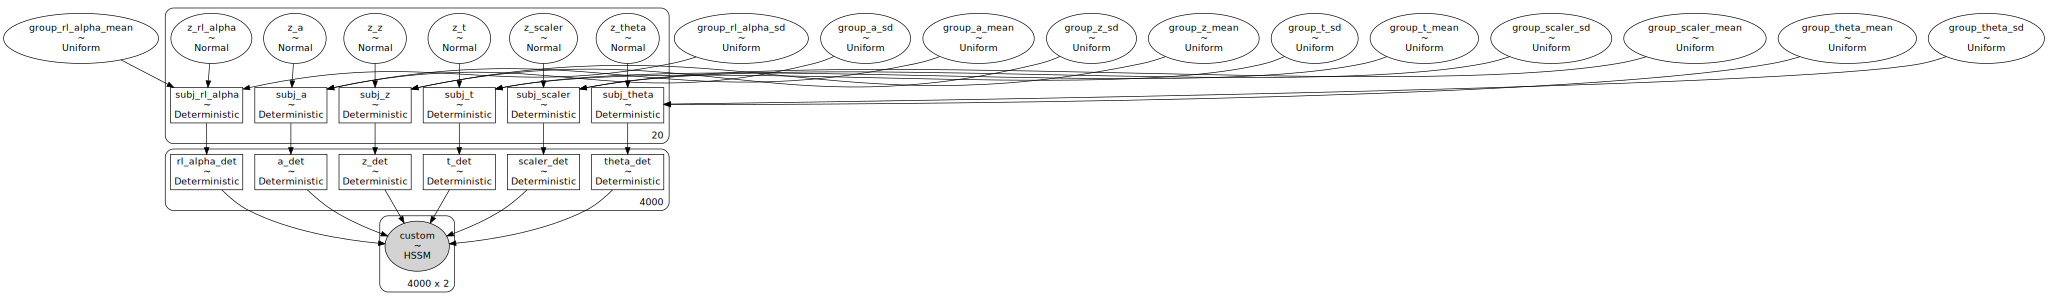

In [13]:
# visualize the model
pm.model_to_graphviz(model)

In [14]:
# sample from the model using NUTS sampler with NumPyro backend
with model:
    idata = pm.sample(draws=500, tune=1000, chains=1, nuts_sampler="numpyro")

sample: 100%|██████████| 1500/1500 [13:54<00:00,  1.80it/s, 31 steps of size 1.44e-01. acc. prob=0.91]   
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Assess the model fits

We examine the quality of fits by comparing the recovered parameters with the ground-truth data generating parameters of the simulated dataset. 
We examine the quality of fits both at group-level as well as subject-level.

In [15]:
# list of group-level parameters
var_names_group_mean = [
    "group_rl_alpha_mean",
    "group_scaler_mean",
    "group_a_mean",
    "group_z_mean",
    "group_t_mean", 
    "group_theta_mean",
]

In [16]:
# print the ground truth group means from the savefile
print("Ground truth group means:")
savefile['params_true_group']

Ground truth group means:


{'rl_alpha_mean': 0.6599748892148676,
 'rl_alpha_std': 0.03361741613298558,
 'scaler_mean': 2.784958224189237,
 'scaler_std': 0.11254334695285723,
 'a_mean': 1.4813726831343665,
 'a_std': 0.06833257048261644,
 'z_mean': 0.2669095905671848,
 'z_std': 0.029806013334481733,
 't_mean': 0.44266787531912977,
 't_std': 0.014493710805742526,
 'theta_mean': 0.31170111158943425,
 'theta_std': 0.03531698660560417}

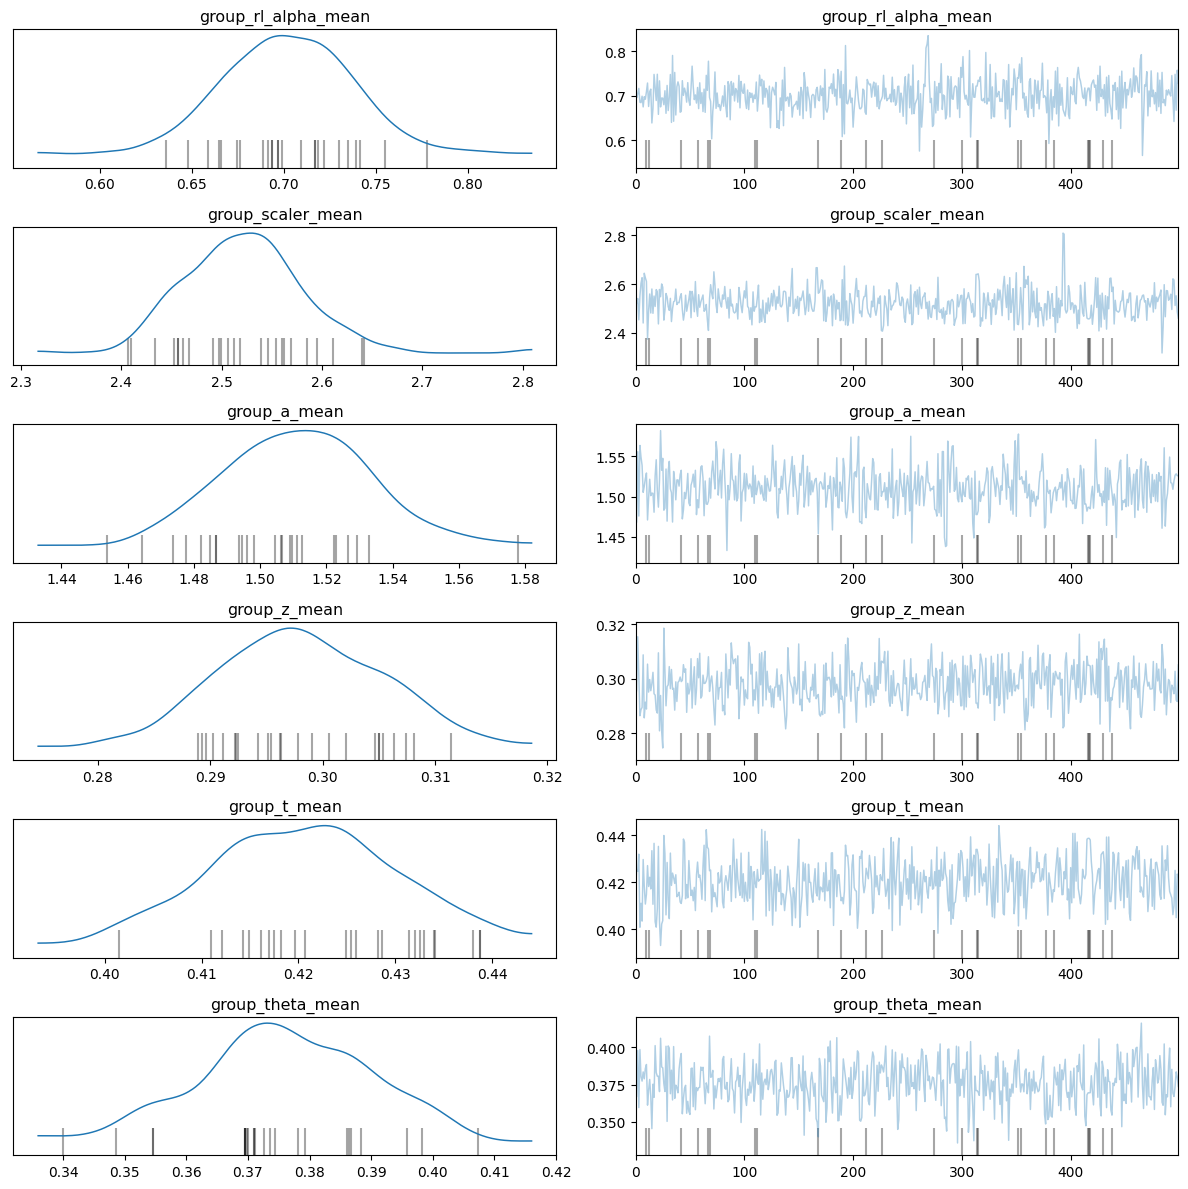

In [17]:
# plot the posterior distributions and traces of the group-level parameters
az.plot_trace(idata, var_names=var_names_group_mean)
plt.tight_layout()

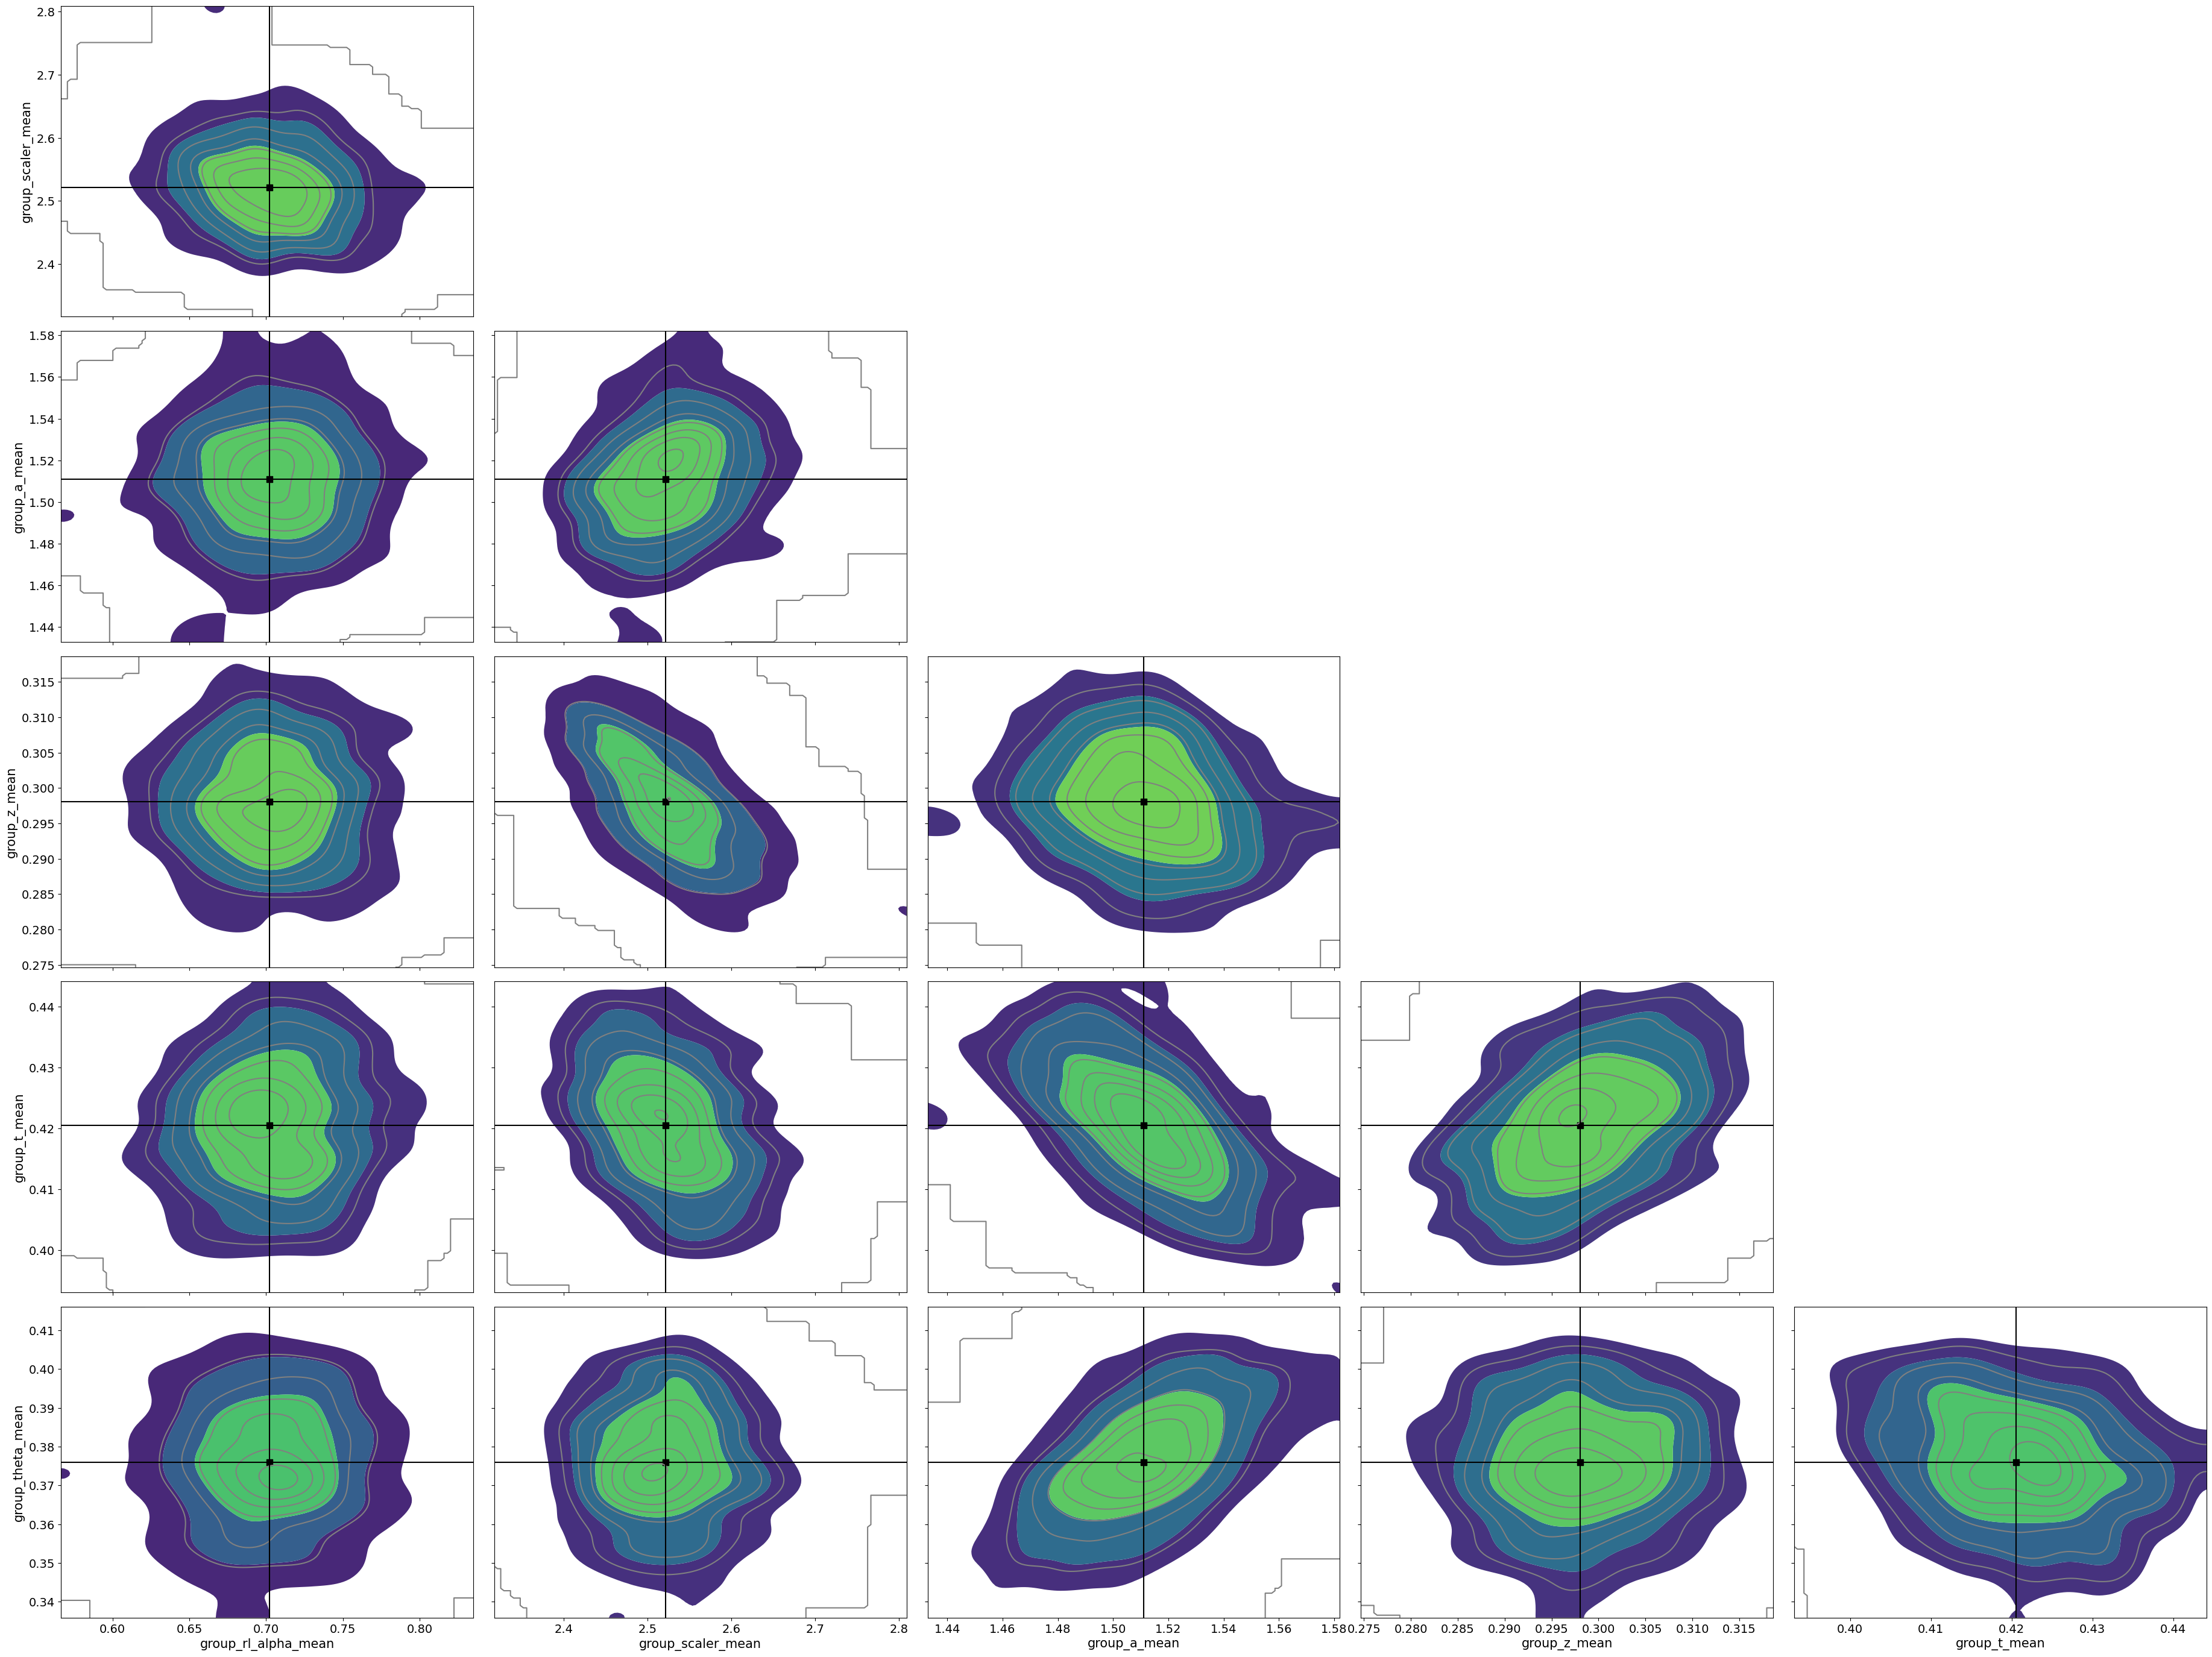

In [25]:
# plot the posterior pair plots of the group-level parameters
# this will show the joint distributions and correlations between the group-level parameters.
az.plot_pair(idata, var_names=var_names_group_mean, kind='kde', point_estimate='mean')
plt.tight_layout()

In [19]:
# transform the log_alpha parameter to its original scale
log_alpha_trace = idata.posterior["subj_rl_alpha"]
alpha_trace = np.exp(log_alpha_trace)
idata.posterior["subj_rl_alpha_orig"] = alpha_trace

In [20]:
# list of subject-level parameters
var_names_subj = [
    "subj_rl_alpha",
    "subj_scaler",
    "subj_a",
    "subj_z",
    "subj_t",
    "subj_theta",
]

In [21]:
# helper function to get the subject-level mean of the parameters from the posterior
def get_plot_data(posterior_idata, var_names_subj, hdi_prob=0.85):
    plot_data = {}
    for p_name in var_names_subj:
        if p_name == 'subj_alpha':
            access_p_name = 'subj_alpha_orig'
        else:
            access_p_name = p_name
        az_summary = az.summary(posterior_idata, var_names=[access_p_name], hdi_prob=hdi_prob, kind='stats', round_to=6)
        plot_data[p_name] = az_summary.values

        # get hdi columns in terms of the +/- range of mean (instead of the absolute values)
        plot_data[p_name][:, 2] = np.abs(plot_data[p_name][:, 2] - plot_data[p_name][:, 0])
        plot_data[p_name][:, 3] = np.abs(plot_data[p_name][:, 3] - plot_data[p_name][:, 0])
    
    return plot_data

In [22]:
plot_data = get_plot_data(idata, var_names_subj)

In [23]:
sim_param_list = np.zeros((20, 6))

for ind, p in enumerate(savefile['params_true_subj'].keys()):
    sim_param_list[:, ind] = savefile['params_true_subj'][p]

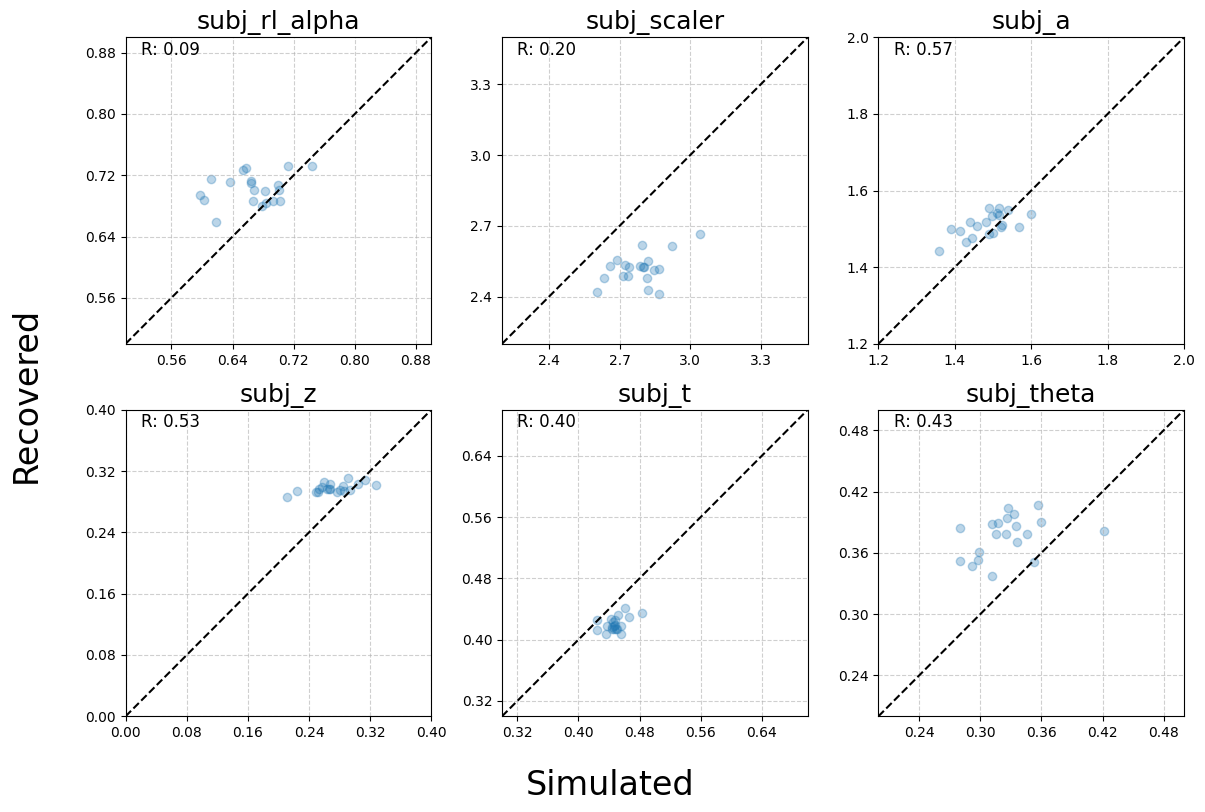

In [24]:
# plot the ground truth vs recovered parameters

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

axes_lims = [[0.5, 0.9], [2.2, 3.5], [1.2, 2], [0, 0.4], [0.3, 0.7], [0.2, 0.5]]

for i, ax in enumerate(axes):
    if i >= len(var_names_subj):
        ax.set_visible(False)
        continue

    x = sim_param_list[:, i]
    y = plot_data[var_names_subj[i]][:, 0]

    # Scatter plot 
    ax.scatter(x, y, alpha=0.3)

    # Calculate Spearman's R
    spearman_r, _ = spearmanr(x, y)

    # Add Spearman's R to the plot
    ax.text(0.05, 0.93, f"R: {spearman_r:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='bottom')

    # Customize subplot
    ax.set_title(var_names_subj[i], fontsize=18)
    ax.set_xlim(axes_lims[i])
    ax.set_ylim(axes_lims[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axline((0, 0), linestyle='--', slope=1, c='k')


fig.text(0.5, 0.00, 'Simulated', ha='center', fontsize=24)
fig.text(0.00, 0.5, 'Recovered', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()